In [1]:
#google drive'a bağlanma

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
##### Veri setini yükleme #####
import os
import cv2


dataset_path = "/content/drive/My Drive/Colab/inme-hastaligi/healthcare-dataset-stroke-data.csv"

In [6]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [9]:
# EDA

df = pd.read_csv(dataset_path)
df = df.drop(["id"], axis=1)

df.info()

describe = df.describe()
print(tabulate(describe, headers='keys', tablefmt='grid'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB
+-------+-----------+----------------+-----------------+---------------------+------------+-------------+
|       |       age |   hypertension |   heart_disease |   avg_glucose_level |        bmi |      st

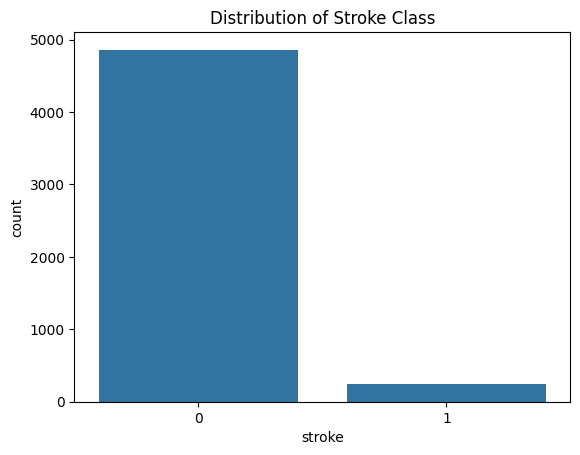

In [10]:
#stroke etiketinin dağılımı (hasta veya değil)

plt.figure()
sns.countplot(x="stroke", data=df)
plt.title("Distribution of Stroke Class")
plt.show()



Dengesiz veri seti
4800 -> 0
250 -> 1

Yanılmamak için:
1.Confusion matrix
2.f1 score

Dengesiz veri seti çözümü:
- stroke = 1 sayısını artırmak
- down sampling (0) sayısını azalt, veri kayb olur

In [11]:
#missing value

df. isnull().sum()
print(df.isnull().sum())


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [12]:
#missing value 2

DT_bmi_pipe = Pipeline(steps = [
    ('scale', StandardScaler()),  #veriyi standartlaştırmak için standart scaler
    ('dtr', DecisionTreeRegressor())  # karar ağacı regresyon modeli
])

X = df[["gender", "age", "bmi"]].copy()

#gender sütununda bulunan değerleri sayısal değerlere dönüştürüyoruz
# male -> 0, female -> 1, other -> -1

X.gender = X.gender.replace({"Male": 0, "Female": 1, "Other": -1}).astype(np.uint8)

#bmi değerleri eksik olan nan satırları ayır
missing = X[X.bmi.isna()]

#bmi değeri eksik olmayanları ayıralım
X = X[~X.bmi.isna()]
y = X.pop("bmi")

# odeli eksik olmayan verilerle eğit
DT_bmi_pipe.fit(X, y)

#eksik bmi değerlerini tahmin edelim, tahmin yapılırken gender ve age kullanılacak
predicted_bmi = pd.Series(DT_bmi_pipe.predict(missing[["gender", "age"]]), index=missing.index)

df.loc[missing.index, "bmi"] = predicted_bmi


In [13]:
#model prediction:  encoding,trainig and testing

df["gender"] = df["gender"].replace({"Male": 0, "Female": 1, "Other": -1}).astype(np.uint8)
df["Residence_type"] = df["Residence_type"].replace({"Urban": 1, "Rural": 0}).astype(np.uint8)
df["work_type"] = df["work_type"].replace({
    "Private": 0,
    "Self-employed": 1,
    "Govt_job": 2,
    "children": -1,
    "Never_worked": -2
}).astype(np.uint8)

X = df[["gender","age","hypertension","heart_disease","work_type","Residence_type","avg_glucose_level","bmi"]]
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

logreg_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('logreg', LogisticRegression())
])

logreg_pipe.fit(X_train, y_train)

#modelin testi
y_pred = logreg_pipe.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Doğruluk Oranı: {accuracy:.4f}")

Doğruluk Oranı: 0.9452


In [15]:
# model save and reload, real error test

import joblib

import joblib

# Google Drive'a kayıt
model_save_path = '/content/drive/My Drive/Colab/inme-hastaligi/inme_hastaligi_model.pkl'

# modeli kaydet
joblib.dump(logreg_pipe, model_save_path)
print("Model Drive'a kaydedildi:", model_save_path)


Model Drive'a kaydedildi: /content/drive/My Drive/Colab/inme-hastaligi/inme_hastaligi_model.pkl


In [16]:
# modeli yükleme
loaded_model = joblib.load('/content/drive/My Drive/Colab/inme-hastaligi/inme_hastaligi_model.pkl')


In [17]:
# yeni hasta verisi
new_patient_data = pd.DataFrame({
    'gender': [1],
    'age': [55],
    'hypertension': [1],
    'heart_disease': [0],
    'work_type': [0],
    'Residence_type': [1],
    "avg_glucose_level": [75],
    "bmi": [25]
})

# tahmin sonucu
new_patient_data_result = loaded_model.predict(new_patient_data)
print("Tahmin:", new_patient_data_result)

# tahmin olasılığı
new_patient_data_probability = loaded_model.predict_proba(new_patient_data)
print("Olasılık:", new_patient_data_probability)


Tahmin: [0]
Olasılık: [[0.9527776 0.0472224]]


%95 olasılıkla hasta değil
%0,4 olasılıkla hasta